# PERSIPAN PUSTAKA

Pustaka dipakai:
1. selenium
2. beautifulsoup4
3. paddleOCR
4. cv2
5. pandas
6. geopandas
7. shapely
8. matplotlib

In [1]:
# Library for Scrape
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup as bs

# Visualization
from matplotlib import pyplot as plt
import cv2

# Text Recognition
from paddleocr import PaddleOCR, draw_ocr

# Polygon Manipulation
from shapely.geometry import Polygon, box

# Dataframe Management
import geopandas as gpd
import pandas as pd

# Runtime Monitoring
import time

Alur:
1. Import file SHP
2. Ekstrak polygon dari kelurahan yang ditentukan
3. Buat grid untuk mempermudah menentukan lokasi screenshot
    * Lakukan screenshot untuk dua level zoom mengetahui resolusi yang tersedia
    * ukuran grid ditentukan berdasarkan resolusi yang diperoleh
4. Buat screenshot layar berdasarkan grid yang terbentuk
5. Dapatkan nama tempat dengan ocr, sekaligus koordinat pada layar
6. Hapus teks yang merupakan menu dari Google Maps
7. Hapus teks yang berupa nama jalan
8. Klik setiap nama tempat yang didapat
9. Dapatkan koordinat POI melalui link
10. Dapatkan detail dari tempat menggunakan bs4
11. Ulangi tahapan 4 - 10 untuk setiap grid yan didapat

# CONFIG PARAMETER

In [2]:
#path shp file
path_shp = "SHPFile Kota Sukabumi/3272.shp"

#pilih kelurahan
kecamatan = "Cikole"
kelurahan = "Cikole"

#folder output
path_output = "output/"

# CONFIG SELENIUM DRIVER AND BROWSER

In [3]:
#windows option
chrome_options = Options()
chrome_options.add_argument("--start-maximized") # windows size
chrome_options.add_experimental_option("detach",True)

#zoom gmaps
zoom1 = 20
zoom2 = 20.5
zoom3 = 21

#test coordinat
lat_test = -6.7135171
long_test = 107.6786505
#x=long; y=lat

# CALCULATE GRID SIZE

In [4]:
def calculate_grid_size(x, y, zoom_level):
    x_size = (x/256)*(360/2**zoom_level)
    y_size = (y/256)*(360/2**zoom_level)
    return x_size, y_size

# MAKE A GRID FROM MAPS

In [5]:
# Fungsi untuk membagi poligon menjadi grid persegi panjang
def create_grid(polygon:gpd.geoseries.GeoSeries, x_size:int, y_size:int):
    minx, miny, maxx, maxy = float(polygon.bounds["minx"]), float(polygon.bounds["miny"]), float(polygon.bounds["maxx"]), float(polygon.bounds["maxy"])  # Mendapatkan batas-batas poligon
    
    # Menentukan jumlah grid yang dibutuhkan dalam arah x dan y
    x_steps = int((maxx - minx) / x_size)
    y_steps = int((maxy - miny) / y_size)
    
    grid = []
    
    # Membuat persegi panjang di dalam area yang tercover poligon
    for i in range(x_steps):
        for j in range(y_steps):
            # Menentukan koordinat persegi panjang
            x0 = minx + i * x_size * 0.995
            y0 = miny + j * y_size * 0.995
            x1 = x0 + x_size
            y1 = y0 + y_size
            
            # Membuat persegi panjang dengan koordinat tersebut
            rect = box(x0, y0, x1, y1)
            
            # Memeriksa apakah persegi panjang tumpang tindih dengan poligon
            if rect.intersects(polygon.values):
                grid.append(rect)
    
    return gpd.GeoDataFrame(geometry=grid, crs="EPSG:4326")

# GET CENTROID FOR EACH GRID

In [6]:
def get_centroid(grid_list:gpd):
    grid_list["centroid"] =  grid_list.geometry.centroid
    return grid_list

# GET GMAPS LINK

In [7]:
def get_gmaps_link(lat, long, zoom_level):
    return f"https://www.google.com/maps/@{lat},{long},{zoom_level}z?"

# SCREENSHOOT

In [8]:
def make_screenshot(driver:webdriver.Chrome, link:str, save_to:str):
    driver.get(link)
    driver.save_screenshot(save_to)

    return save_to

# GET IMAGE RESOLUTION

In [9]:
def get_image_resolution(image_path:str):
    img = cv2.imread(image_path)
    y,x,z = img.shape 
    return x, y #x=lat; y=long

# OCR

In [21]:
def detect_text(image_path):
    # Path
    font_path = "C:/Windows/Fonts/arial.ttf"

    # Initialize OCR
    ocr = PaddleOCR(use_angle_cls= True, lang = "en", ocr_version='PP-OCRv4', vis_font_path=font_path)

    # Perform OCR
    result = ocr.ocr(image_path, cls=True, bin=True, inv=True)

    # Visualization
    # Get the bounding box and corresponding text
    boxes = [line[0] for line in result[0]]
    txts = [line[1][0] for line in result[0]]
    scores = [line[1][1] for line in result[0]]

    boxes_centroid = [Polygon(line).centroid for line in boxes]

    return pd.DataFrame({'text': txts, 'scores': scores, 'boxes': boxes, 'centroid':boxes_centroid})

# SAVE IMAGE WITH BOXES

In [11]:
def save_image_with_boxes(image_path, boxes, save_to:str):
    # Load the image
    image = cv2.imread(image_path)

    image_with_boxes = draw_ocr(image, boxes)

    # Convert the image from BGR to RGB (OpenCV loads images in BGR)
    image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    plt.imshow(image_with_boxes)
    plt.savefig(save_to)

# CLEANING TEXT

In [12]:
def cleaning_text(df_text):
    # Hapus Menu Google

    # Hapus Kata Terpotong
    return df_text

# COLLECT PLACE

# GET PLACE'S DETAIL

In [13]:
tag = "!4m6!3m5!1s0x2e68498154b496b1:0x8ce79800c09324a2!8m2!3d-6.9199873!4d106.9417309!16s%2Fg%2F11s7w8jwvg?entry=ttu&g_ep=EgoyMDI0MTAyOS4wIKXMDSoASAFQAw%3D%3D"

# EXECUTE

[2024/11/06 13:44:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\MYPC PRO L7/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\MYPC PRO L7/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', re

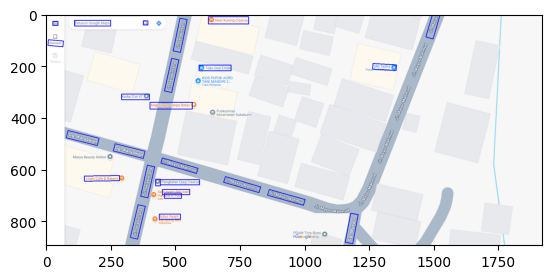

In [22]:
#initiate browser
driver = webdriver.Chrome(options=chrome_options)

# first screenshoot
path_first_screenshoot = make_screenshot(driver, get_gmaps_link(lat_test, long_test, zoom1), f"{path_output}/screenshoot_zoom_1.png")

# Periksa ukuran resolusi gambar
res_x, res_y = get_image_resolution(path_first_screenshoot)

# Import SHP
geo_df_kota = gpd.read_file(path_shp)
geo_df_kota.head()
geo_kelurahan = geo_df_kota[(geo_df_kota["WADMKC"]==kecamatan) & (geo_df_kota["WADMKD"]==kelurahan)]["geometry"]

# grid size
x1_size, y1_size = calculate_grid_size(res_x,res_y,zoom1)
x2_size, y2_size = calculate_grid_size(res_x,res_y,zoom2)
x3_size, y3_size = calculate_grid_size(res_x,res_y,zoom3)

# make grid maps
grid1 = create_grid(geo_kelurahan,x1_size,y1_size)
grid3 = create_grid(geo_kelurahan,x3_size,y3_size)

# centroid of each grid
grid1 = get_centroid(grid1)
grid3 = get_centroid(grid3)

# Initiate Dataframe hasil
df_result = pd.DataFrame()

#looping 1
for i in range(len(grid3)):
    l = get_gmaps_link(round(grid3['centroid'][i].y,7), round(grid3['centroid'][i].x,7),zoom3)
    img = make_screenshot(driver, l,f"{path_output}screenshoot/zoom3_{i+1}.png")
    result = detect_text(img)
    save_image_with_boxes(img,result['boxes'],f"{path_output}ocr_result/zoom3_{i+1}.png")
    clean_result = cleaning_text(result)

driver.quit()